# Taylor Swift Lyrics Analysis: A Data-Driven Exploration

A personal research project analyzing Taylor Swift's lyrics through computational text analysis. This analysis explores patterns in Taylor Swift's songwriting, with a particular focus on her use of temporal references (day/night) and sentiment analysis across her discography.

*Data source: Original dataset curated by Jan Llenzl Dagohoy and published on [Kaggle](https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums)*


In [1]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


## Data Collection and Preprocessing

The primary dataset contains Taylor Swift's lyrics from 2006-2020, with additional data from the Midnights album (2022) included for completeness. Initial steps involve loading and preprocessing the dataset to prepare for our analysis:

* Loading the primary dataset (taylor_swift_lyrics_2006-2020_all.csv)
* Examining dataset structure and characteristics
* Checking for data quality issues and missing values


*Note: The analysis includes lyrics from the Midnights album (2022) through a supplementary dataset to ensure comprehensive coverage of Swift's discography.*

In [2]:
# load dataset
lyrics = pd.read_csv("taylor_swift_lyrics_2006-2020_all.csv")

#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5


In [3]:
#get info about the DataFrame
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8358 entries, 0 to 8357
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   8358 non-null   object
 1   track_title  8358 non-null   object
 2   track_n      8358 non-null   int64 
 3   lyric        8358 non-null   object
 4   line         8358 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 326.6+ KB


### Temporal Metadata Enhancement

To enable chronological analysis of Swift's lyrical evolution, we need to augment our dataset with release year information. A custom mapping function will be used to associate each album with its release year.

### 2. Add essential data

We know that we want to explore her use of terms over years, but this dataset doesn't have years. We can either merge a dataset or manually create a new column. We have created a function for you that fills in the year based on the album name. 

* Apply this function to the `lyrics` DataFrame to create a new column.

In [4]:
# get a list of all the albums in this collection
print(lyrics.album_name.unique())

['Fearless (Taylor’s Version)' 'Red (Deluxe Edition)' '1989 (Deluxe)'
 'reputation' 'Taylor Swift' 'folklore (deluxe version)' 'Lover'
 'evermore (deluxe version)' 'Speak Now (Deluxe)']


In [6]:
# this is a function to map the name of the album to the year it was released
def album_release(row):  
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    #ok, we know folklore was actually released in Dec 2020, but this will make our analysis easier
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    #this is slightly differently formatted because the album name is recorded two ways.
    elif 'midnights' in row['album_name']:
        return '2022'
    
    return 'No Date'

# apply the function to the album
lyrics['album_year'] = lyrics.apply(lambda row: album_release(row), axis=1)

# inspect the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008


### Text Preprocessing Pipeline

To ensure consistent and accurate analysis of keyword frequencies, the following text preprocessing steps are implemented:

* Conversion to lowercase for standardization
* Removal of punctuation marks
* Filtering of common stop words

The processed text will be stored in a new `clean_lyric` column for subsequent analysis.

In [8]:
#lowercase
lyrics['clean_lyric'] = lyrics['lyric'].str.lower()

#remove punctuation
lyrics['clean_lyric']= lyrics['clean_lyric'].str.replace('[^\w\s]','')
lyrics.head()

#remove stopwords (see the next cell for illustration)
#create a small list of English stop words, feel free to edit this list
stop = ['the', 'a', 'this', 'that', 'to', 'is', 'am', 'was', 'were', 'be', 'being', 'been']


#there are three steps in one here - explained below
#we make a list of words with `.split()`
#then we remove all the words in our list
#then we join the words back together into a string
lyrics['clean_lyric'] = lyrics['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car"
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah"


In [9]:
#see what `.split()` does
lyrics['clean_lyric_list'] = lyrics['clean_lyric'].apply(lambda x: x.split())
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                     there's something 'bout way   
1              street 

In [10]:
#see what `.join()` does
lyrics['clean_lyric_list_rejoined'] = lyrics['clean_lyric_list'].apply(lambda x: ' '.join(x))
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                     there's something 'bout way   
1              street 

In [11]:
#remove those illustration columns
lyrics.drop(['clean_lyric_list', 'clean_lyric_list_rejoined'], axis=1, inplace=True)
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  
0                     there's something 'bout way  
1              street lo

In [13]:
# there are many pre-built lists of stopwords, we'll use NLTK's list
# Most exclude too many words to be appropriate for song lyric analysis.
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk_stop = set(stopwords.words('english'))
print(nltk_stop)

{"it'd", 'am', 'or', "they'd", 'so', 'the', 'herself', 'were', "wouldn't", 'a', 'other', 'what', 'wasn', 'itself', 'isn', 'no', 'him', 'further', 'between', "i've", 'yours', 've', 'more', 'to', 'up', "we'll", 'myself', 'over', 'then', 'has', 'ours', 'they', 'few', 'm', "i'll", "he's", 'again', "it'll", 'don', "shan't", 'against', "weren't", 'himself', 'hadn', "mustn't", 'into', "they've", "aren't", 'those', 'didn', 'too', 'than', 'weren', 'did', "doesn't", "hasn't", 'was', "we're", 'there', 'mustn', 'during', 'her', 'i', 'in', 'now', 'should', 'some', 'about', 'below', 'have', 'o', 'wouldn', 'here', 'nor', 'had', 'is', 'hers', 'if', 'on', 'out', 'we', 'this', 'yourself', 'shouldn', "don't", 'and', 'our', "she's", "you've", 'such', 'from', 'just', "i'd", "she'll", 'above', "haven't", 'them', 'whom', 'she', 'you', "you'll", 'being', 'through', 'until', "needn't", "we'd", 'he', 'most', 'for', 'same', 'ourselves', 'theirs', 'd', "hadn't", 'why', "they're", "shouldn't", 'ain', 'all', 'are',

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raksharane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Initial Temporal Reference Analysis

As a starting point for our temporal analysis, we first examine the frequency of 'midnight' in Swift's lyrics. This serves as our baseline temporal reference before expanding to a broader vocabulary of time-related terms.

* Create a new column to indicate if a lyric has "midnight" in it.
* Check how many times midnight occurrs

In [14]:
#create a new column to reflect if the lyrics contain midnight
lyrics['midnight'] = lyrics['clean_lyric'].str.contains('midnight')
sum(lyrics['midnight'])

# ---
# Extended Temporal Reference Analysis
#
# To comprehensively analyze Swift's use of temporal references, we expand our analysis to include a broader set of time-related terms. We categorize these terms into three main groups:
# - Night-related terms (e.g., 'night', 'midnight', 'dawn', 'dusk')
# - Day-related terms (e.g., 'day', 'morning', 'sun')
# - General time references (e.g., 'today', 'tomorrow', 'yesterday')
#
# This categorization allows us to examine patterns in Swift's temporal imagery across her discography.

9

### Expanded Temporal Vocabulary Analysis

To capture the full range of Swift's temporal references, we develop comprehensive word lists for different temporal categories:

* Night-related terminology (e.g., 'night', 'midnight', 'dawn', 'dusk')
* Day-related terminology (e.g., 'day', 'morning', 'sun')
* General time references (e.g., 'today', 'tomorrow', 'yesterday')

These categorized word lists will be used to create regular expressions for systematic pattern matching across the lyrics.

In [15]:
#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

#create a regular expression string for each list of words
night_regex = '|'.join(night)
day_regex = '|'.join(day)
time_regex = '|'.join(time)

#create a new column for each category of words
lyrics['night'] = lyrics['clean_lyric'].str.contains(night_regex)
lyrics['day'] = lyrics['clean_lyric'].str.contains(day_regex)
lyrics['time'] = lyrics['clean_lyric'].str.contains(time_regex)

#count the number of times each category of word appears in the lyrics
night_count = sum(lyrics['night'])
day_count = sum(lyrics['day'])
time_count = sum(lyrics['time'])

#print the count of each word category
print("night words: ", night_count)
print("day words: ", day_count)
print("time words: ", time_count)

#inspect the first few rows
lyrics.head()

night words:  240
day words:  363
time words:  35


,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False


### Temporal Reference Evolution Analysis

To understand how Swift's use of temporal references has evolved over her career, we'll analyze the frequency of time-related terms across her discography. This analysis will reveal any patterns or trends that might indicate thematic shifts in her songwriting:

* Creating a chronological analysis of temporal references by year
* Visualizing trends in night-related imagery over time

In [16]:
#create a new dataframe for yearly mentions that groups mentions by year
yearly_mentions = lyrics.groupby('album_year').sum().reset_index()
yearly_mentions

,album_year,album_name,track_title,track_n,lyric,line,clean_lyric,midnight,night,day,time
0,2006,Taylor SwiftTaylor SwiftTaylor SwiftTaylor Swi...,Tim McGrawTim McGrawTim McGrawTim McGrawTim Mc...,4867,He said the way my blue eyes shinedPut those G...,13456,he said way my blue eyes shinedput those georg...,0,19,25,3
1,2008,Fearless (Taylor’s Version)Fearless (Taylor’s ...,Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,there's something 'bout waystreet looks when i...,0,42,65,20
2,2010,Speak Now (Deluxe)Speak Now (Deluxe)Speak Now ...,MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,"you in college, working part-time, waiting tab...",0,31,53,4
3,2012,Red (Deluxe Edition)Red (Deluxe Edition)Red (D...,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,i'm walking fast through traffic lightsbusy st...,1,48,53,7
4,2014,1989 (Deluxe)1989 (Deluxe)1989 (Deluxe)1989 (D...,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,"walking through crowd, village aglowkaleidosco...",2,27,41,0
5,2017,reputationreputationreputationreputationreputa...,...Ready for It?...Ready for It?...Ready for I...,7640,Knew he was a killer first time that I saw him...,33775,knew he killer first time i saw himwondered ho...,3,25,25,0
6,2019,LoverLoverLoverLoverLoverLoverLoverLoverLoverL...,I Forgot That You ExistedI Forgot That You Exi...,8813,How many days did I spend thinking'Bout how yo...,25741,how many days did i spend thinking'bout how yo...,0,22,46,0
7,2020,evermore (deluxe version)evermore (deluxe vers...,willowwillowwillowwillowwillowwillowwillowwill...,8443,I'm like the water when your ship rolled in th...,25712,i'm like water when your ship rolled in nightr...,2,18,38,0
8,2021,folklore (deluxe version)folklore (deluxe vers...,the 1the 1the 1the 1the 1the 1the 1the 1the 1t...,6193,"I'm doing good, I'm on some new shitBeen sayin...",16854,"i'm doing good, i'm on some new shitsaying ""ye...",1,8,17,1


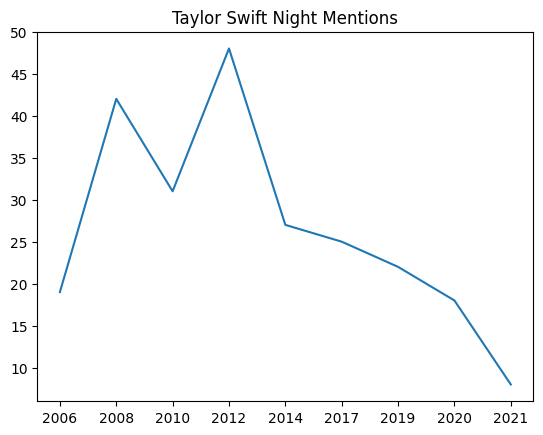

In [17]:
#plot the mentions of night over years
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'])
plt.title("Taylor Swift Night Mentions")
plt.show()

### Album-Level Temporal Analysis

To identify albums with the strongest temporal themes, we'll merge our frequency analysis with album metadata. This will help us understand which periods in Swift's career showed the most pronounced focus on day/night imagery.

### 7. What albums are the most night/day focused?
Now that we have a table of counts, it's very easy to figure out which albums have the most mentions of day or night. But our DataFrame only has the years, not the album names. We need to add those back in.
* Run the code that reinstates the album name for this dataframe.
* Use `.sort_values()` to order the yearly_mentions table and find which year has the most mentions of night.
* Do the same for the day column.

In [18]:
#reinstate the album name
#read the album_year_name.csv
year_name = pd.read_csv('album_year_name.csv')

#sort both dataframes by year
yearly_mentions.sort_values(by='album_year', ascending=True, inplace=True)
year_name.sort_values(by='album_year', ascending=True, inplace=True)

#add the new column for album name
yearly_mentions['album_name'] = year_name['album_name']

In [19]:
#sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values(by='night', ascending=False)

,album_year,album_name,track_title,track_n,lyric,line,clean_lyric,midnight,night,day,time
3,2012,reputation,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,i'm walking fast through traffic lightsbusy st...,1,48,53,7
1,2008,Red (Deluxe Edition),Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,there's something 'bout waystreet looks when i...,0,42,65,20
2,2010,1989 (Deluxe),MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,"you in college, working part-time, waiting tab...",0,31,53,4
4,2014,Taylor Swift,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,"walking through crowd, village aglowkaleidosco...",2,27,41,0
5,2017,folklore (deluxe version),...Ready for It?...Ready for It?...Ready for I...,7640,Knew he was a killer first time that I saw him...,33775,knew he killer first time i saw himwondered ho...,3,25,25,0
6,2019,Lover,I Forgot That You ExistedI Forgot That You Exi...,8813,How many days did I spend thinking'Bout how yo...,25741,how many days did i spend thinking'bout how yo...,0,22,46,0
0,2006,Fearless (Taylor’s Version),Tim McGrawTim McGrawTim McGrawTim McGrawTim Mc...,4867,He said the way my blue eyes shinedPut those G...,13456,he said way my blue eyes shinedput those georg...,0,19,25,3
7,2020,evermore (deluxe version),willowwillowwillowwillowwillowwillowwillowwill...,8443,I'm like the water when your ship rolled in th...,25712,i'm like water when your ship rolled in nightr...,2,18,38,0
8,2021,Speak Now (Deluxe),the 1the 1the 1the 1the 1the 1the 1the 1the 1t...,6193,"I'm doing good, I'm on some new shitBeen sayin...",16854,"i'm doing good, i'm on some new shitsaying ""ye...",1,8,17,1


In [20]:
#sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values(by='day', ascending=False)

,album_year,album_name,track_title,track_n,lyric,line,clean_lyric,midnight,night,day,time
1,2008,Red (Deluxe Edition),Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,there's something 'bout waystreet looks when i...,0,42,65,20
2,2010,1989 (Deluxe),MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,"you in college, working part-time, waiting tab...",0,31,53,4
3,2012,reputation,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,i'm walking fast through traffic lightsbusy st...,1,48,53,7
6,2019,Lover,I Forgot That You ExistedI Forgot That You Exi...,8813,How many days did I spend thinking'Bout how yo...,25741,how many days did i spend thinking'bout how yo...,0,22,46,0
4,2014,Taylor Swift,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,"walking through crowd, village aglowkaleidosco...",2,27,41,0
7,2020,evermore (deluxe version),willowwillowwillowwillowwillowwillowwillowwill...,8443,I'm like the water when your ship rolled in th...,25712,i'm like water when your ship rolled in nightr...,2,18,38,0
0,2006,Fearless (Taylor’s Version),Tim McGrawTim McGrawTim McGrawTim McGrawTim Mc...,4867,He said the way my blue eyes shinedPut those G...,13456,he said way my blue eyes shinedput those georg...,0,19,25,3
5,2017,folklore (deluxe version),...Ready for It?...Ready for It?...Ready for I...,7640,Knew he was a killer first time that I saw him...,33775,knew he killer first time i saw himwondered ho...,3,25,25,0
8,2021,Speak Now (Deluxe),the 1the 1the 1the 1the 1the 1the 1the 1the 1t...,6193,"I'm doing good, I'm on some new shitBeen sayin...",16854,"i'm doing good, i'm on some new shitsaying ""ye...",1,8,17,1


### Comparative Analysis: Day vs. Night References

A direct comparison of day and night references across albums will help identify any patterns in Swift's use of temporal contrasts and whether there's a preference for certain types of temporal imagery in different periods.

* Create another line chart with both the night mentions and the day mentions

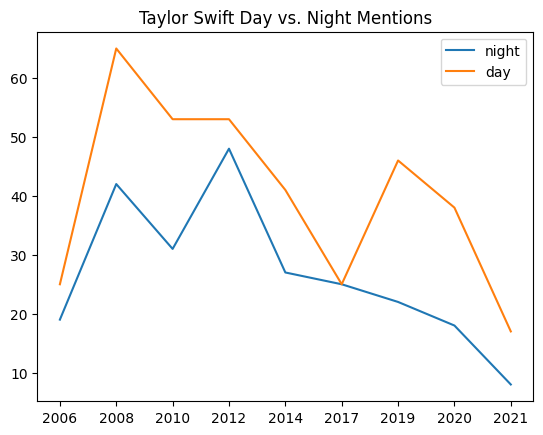

In [21]:
#create a plot with one line showing number of night references by year 
#and another line with the number of day references by year
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'], label = 'night')
plt.plot(yearly_mentions['album_year'], yearly_mentions['day'], label = 'day')
plt.title("Taylor Swift Day vs. Night Mentions")
plt.legend()
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Research Insight!</i></summary>

Well this is interesting. We see a similar dip in referencing time around 2017, but a sharp increase in both 2019 and 2020 to reference day. 

</details>

### Key Temporal Pattern Observation

The analysis reveals an intriguing pattern in Swift's use of temporal imagery. There's a notable decrease in time-related references around 2017, followed by a significant increase in day-related imagery during 2019-2020. This shift could reflect changes in thematic focus or emotional tone during these periods.

### Intra-Album Temporal Distribution Analysis

To explore the structural use of temporal references within albums, we'll analyze the positioning of day and night references throughout each album's track sequence. This analysis could reveal intentional patterns in how Swift structures temporal imagery within her albums:

* Creating a normalized position metric for lyrics within albums
* Analyzing the distribution of temporal references across album structures
* Visualizing patterns in day/night imagery placement

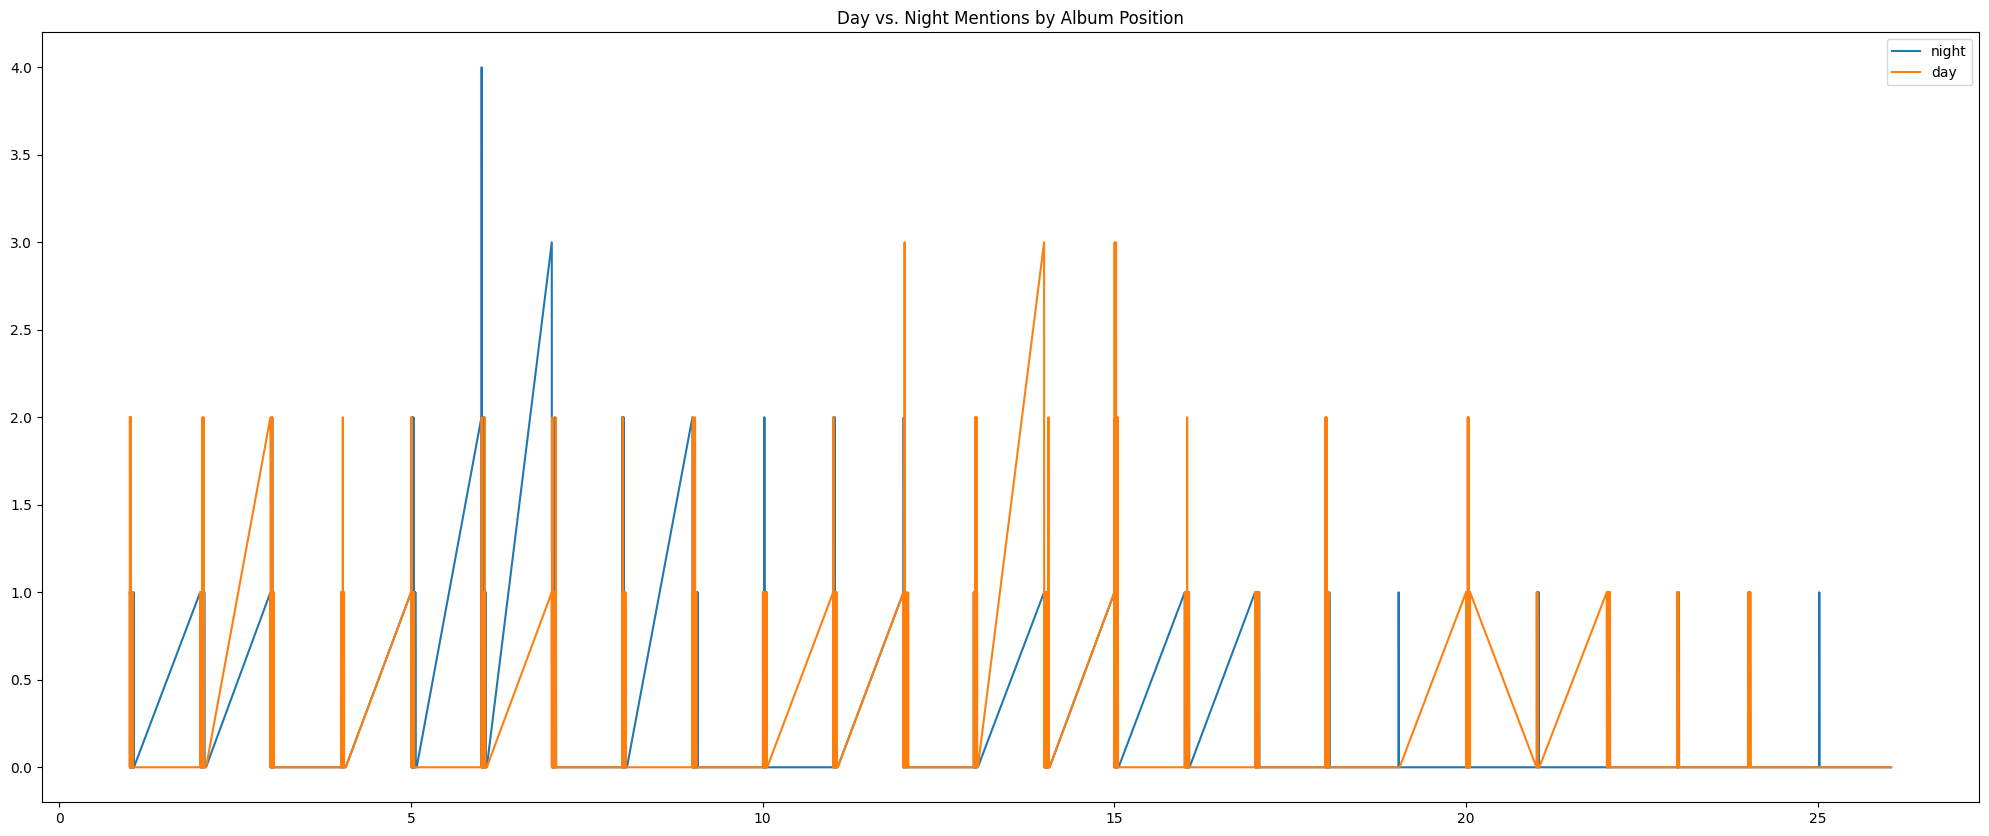

In [22]:
#create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + (lyrics['line']/1000)

#create a new DataFrame that is grouped by position
positional_mentions = lyrics.groupby('position').sum().reset_index()

#increase the size of the plot 
fig = plt.gcf()
fig.set_size_inches(25,10)

#create a plot with two lines to show frequency of day vs. night references by position in the album
plt.plot(positional_mentions['position'], positional_mentions['night'], label = 'night')
plt.plot(positional_mentions['position'], positional_mentions['day'], label = 'day')
plt.legend()
plt.title("Day vs. Night Mentions by Album Position")

plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

    Honestly not that much -- we can't see any strong trends here. Best to move on. 
</details>

# Task Group 3

### 10. Tokenize the Lyrics
It's great to know how much she has focused on day and night, but we would also like to do a little more sophisticated analysis. Before we can work with our cleaned lyrics, we will have to tokenize them. Tokenization is a way of breaking up words. There are a variety of wa. The output is a list of words that we can then perform text analysis on.

Split the words on their space

* Run the cell to tokenize the cleaned lyrics.
* Inspect the first few rows of the lyrics DataFrame
* Create a list of all the tokens in the lyrics_tok column into one list
* Use the Counter function from the collections package to count the number of times each word appears
* Sort the resulting dictionary

In [23]:
#run this cell to tokenize the words in the clean_lyric column
lyrics['lyrics_tok'] = lyrics['clean_lyric'].str.split(' ')

In [24]:
#inspect the first few lines
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False,1.001,"[there's, something, 'bout, way]"
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False,1.002,"[street, looks, when, it's, just, rained]"
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False,1.003,"[there's, glow, off, pavement,, you, walk, me,..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False,1.005,"[in, middle, of, parking, lot,, yeah]"


In [25]:
#determine what words overall are the most frequently used words
#create a list of all the words in the lyrics_tok column
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

#use the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)
#sort the word frequencies to find out the most common words she's used. 
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
#call the word frequency
word_frequency

[('you', 2628),
 ('i', 2431),
 ('and', 1688),
 ('me', 885),
 ('in', 870),
 ('it', 839),
 ('my', 752),
 ('your', 622),
 ('of', 590),
 ('but', 532),
 ('all', 514),
 ('we', 490),
 ("i'm", 484),
 ('like', 475),
 ('know', 426),
 ('on', 404),
 ('so', 394),
 ("don't", 382),
 ('when', 374),
 ("it's", 367),
 ('just', 336),
 ('never', 328),
 ("you're", 310),
 ('for', 299),
 ('with', 297),
 ('what', 277),
 ('at', 246),
 ('if', 242),
 ('love', 242),
 ('now', 237),
 ('out', 237),
 ("'cause", 234),
 ('time', 224),
 ('back', 223),
 ('oh,', 221),
 ('up', 220),
 ('are', 215),
 ('got', 200),
 ('one', 195),
 ('think', 188),
 ('see', 188),
 ('do', 175),
 ('they', 172),
 ('come', 169),
 ('could', 164),
 ('not', 162),
 ('can', 159),
 ('wanna', 158),
 ('down', 156),
 ('go', 155),
 ("can't", 152),
 ('say', 150),
 ('right', 145),
 ('there', 145),
 ('i,', 145),
 ('want', 142),
 ('have', 140),
 ('you,', 139),
 ("i'll", 139),
 ('he', 138),
 ('no', 136),
 ('had', 131),
 ("that's", 129),
 ('look', 127),
 ('me,', 12

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

   She mostly talks about you and then herself, while that's not surprising, it also tells us that she's mostly writing about relationships and her realtionships with others. 
</details>

### 11. Analyze Lyric Sentiment

To better understand how she thinks and feels about day and night, we want to know which one she writes about more favorably. 

We are going to use the pre-trained sentiment classifier that comes with NLTK. It's it trained on tweets and therefore best for short text. It return 4 values: positive, negative, neutral, and compound. Compound will be of special interest to us. It is the normalized sum of positive and negative. 

* Run the sample sentiment analyzer cell to see how the SentimentIntensityAnalyzer works.
* Apply the sia sentiment analyzer to the clean_lyric column of the DataFrame with a lambda expression
* Run the cell that transforms the dictionary into columns of the DataFrame

In [26]:
#run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/raksharane/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
#run this cell to see how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [28]:
#create a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,polarity
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False,1.001,"[there's, something, 'bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False,1.002,"[street, looks, when, it's, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False,1.003,"[there's, glow, off, pavement,, you, walk, me,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False,1.005,"[in, middle, of, parking, lot,, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."


In [29]:
#run this cell to transform the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False,1.001,"[there's, something, 'bout, way]",0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False,1.002,"[street, looks, when, it's, just, rained]",0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False,1.003,"[there's, glow, off, pavement,, you, walk, me,...",0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...",0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False,1.005,"[in, middle, of, parking, lot,, yeah]",0.0,0.694,0.306,0.296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,Speak Now (Deluxe),Superman,17,I'll be right here on the ground,51,2010,i'll right here on ground,False,False,False,False,17.051,"[i'll, right, here, on, ground]",0.0,1.000,0.000,0.000
8354,Speak Now (Deluxe),Superman,17,When you come back down,52,2010,when you come back down,False,False,False,False,17.052,"[when, you, come, back, down]",0.0,1.000,0.000,0.000
8355,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",53,2010,"la, la, la, la, la, la",False,False,False,False,17.053,"[la,, la,, la,, la,, la,, la]",0.0,1.000,0.000,0.000
8356,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",54,2010,"la, la, la, la, la, la",False,False,False,False,17.054,"[la,, la,, la,, la,, la,, la]",0.0,1.000,0.000,0.000


In [30]:
#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False,1.001,"[there's, something, 'bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False,1.002,"[street, looks, when, it's, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False,1.003,"[there's, glow, off, pavement,, you, walk, me,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False,1.005,"[in, middle, of, parking, lot,, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.0,0.694,0.306,0.296


### 12. Corpus Sentiment Analysis

Now that we have sentiment for all of her lyrics, let's learn more about her overall sentiment, as well as how that has change throughout her career. 
* Use the pos, neg, and compound columns to calculate the overall sentiment of her entire collection, and print the result.
* Use the groupby function and matplotlib to visualize the overall sentiment of her albums over time 

In [31]:
#calculate overall sentiment for pos, neg, sentiment
pos = sum(lyrics['pos'])
neg = sum(lyrics['neg'])
compound = sum(lyrics['compound'])

#print the overall sentiments
print("positive: ", pos)
print("negative: ", neg)
print("compound: ", compound)

positive:  1056.0170000000012
negative:  652.3420000000008
compound:  471.3166000000009


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

   Overall Taylor Swift's lyrics are mostly positive! 
</details>

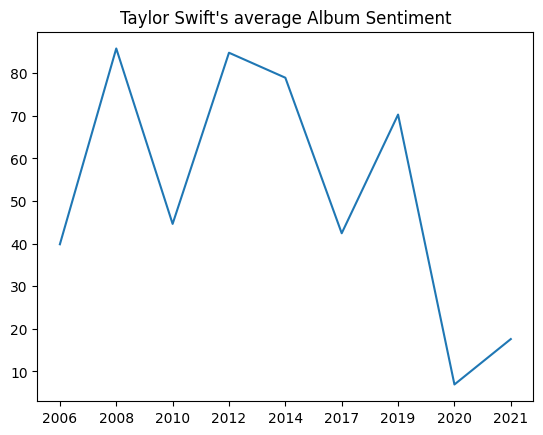

In [32]:
#create a new DataFrame using the groupby method for the album_year
yearly_sentiment = lyrics.groupby('album_year')[['compound', 'neg', 'pos']].sum().reset_index()

#visualize sentiment over time 
plt.plot(yearly_sentiment['album_year'], yearly_sentiment['compound'])
plt.title("Taylor Swift's average Album Sentiment")
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

   Her degree of positivity has really fluctuated over time. Her 2020 album was by far the least positive, though all of her albums are actually positive. 
</details>

### 13. Day or Night? Positive or Negative
Finally the big reveal. Does Taylor Swift write more positively about day or night? 
* Create two DataFrames: one for all the lyrics that mention night and one for all the lyrics that mention day.
* Check that each DataFrame has the right number of values with the `len()` function
* Calculate the sentiment for both night and day using the compound value and print them.

In [33]:
#create a DataFrame filtered for only night mentions
night = lyrics[lyrics['night']==True]

#create a DataFrame filtered for only day mentions
day = lyrics[lyrics['day']==True]

#print the length of the night and day DataFrames
print("night: ",len(night))
print("day: ",len(day))

night:  240
day:  363


In [34]:
#calculate the sentiment of each day and night DataFrame from the compound values
night_sentiment = night['compound'].sum()
day_sentiment = day['compound'].sum()

#print the results
print("night sentiment: ", night_sentiment)
print("day_sentiment: ", day_sentiment)

night sentiment:  17.8324
day_sentiment:  31.6789


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>Research Findings</i></summary>

Based on the sentiment analysis, Taylor Swift maintains a more positive sentiment when referencing 'day' compared to 'night' in her lyrics. This discovery opens up interesting avenues for further research:

- Temporal evolution of sentiment patterns across albums
- Sentiment analysis of her latest work, including Midnights- Correlation between temporal references and thematic elements

This analysis contributes to our understanding of Swift's songwriting patterns and her use of temporal imagery across her discography.
</details>